# Natural Language Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Film Junky Union, a new community for classic film fans, is developing a system to filter and categorize film reviews. Their main mission is to train a model that can automatically detect negative reviews. You will be using the IMBD movie review dataset with polarity labeling to create a model that can classify reviews as positive or negative. This model should have an F1 score of at least 0.85.

## Initialization

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00


In [ ]:
import re
import math
import spacy
import nltk
import torch
import transformers

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<ipython-input-5-3862caad4b17>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Ref: https://pypi.org/project/tqdm/
tqdm.pandas()

## Load Data

In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/FILE PRACTICUM/Sprint 14/Another Mini Project/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
4605,tt0078856,movie,Beyond the Poseidon Adventure,Beyond the Poseidon Adventure,1979,\N,114,0,"Action,Adventure",4.7,4625,This film is in a dead tie with the original f...,2,neg,0,test,3798
41586,tt0827521,video,The Shepherd,The Shepherd,2008,\N,95,0,"Action,Crime,Thriller",5.6,6284,"Worth the entertainment value of a rental, esp...",4,neg,0,test,126
8906,tt0985025,movie,Dark Floors,Dark Floors,2008,\N,85,0,"Action,Fantasy,Horror",4.5,6510,Lordi was a major hype and revelation in 2007 ...,3,neg,0,train,7414
37427,tt0032553,movie,The Great Dictator,The Great Dictator,1940,\N,125,0,"Comedy,Drama,War",8.4,195252,"This is supposed to be Charlie's masterpiece, ...",2,neg,0,test,2180
6463,tt0408309,video,"Carmilla, the Lesbian Vampire",Vampires vs. Zombies,2004,\N,85,0,Horror,1.6,1008,I honestly have to say that I could not stop w...,1,neg,0,train,4134


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [ ]:
df_reviews.duplicated().sum()

0

In [ ]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [ ]:
df_reviews.dropna(axis=0, inplace=True)

## EDA

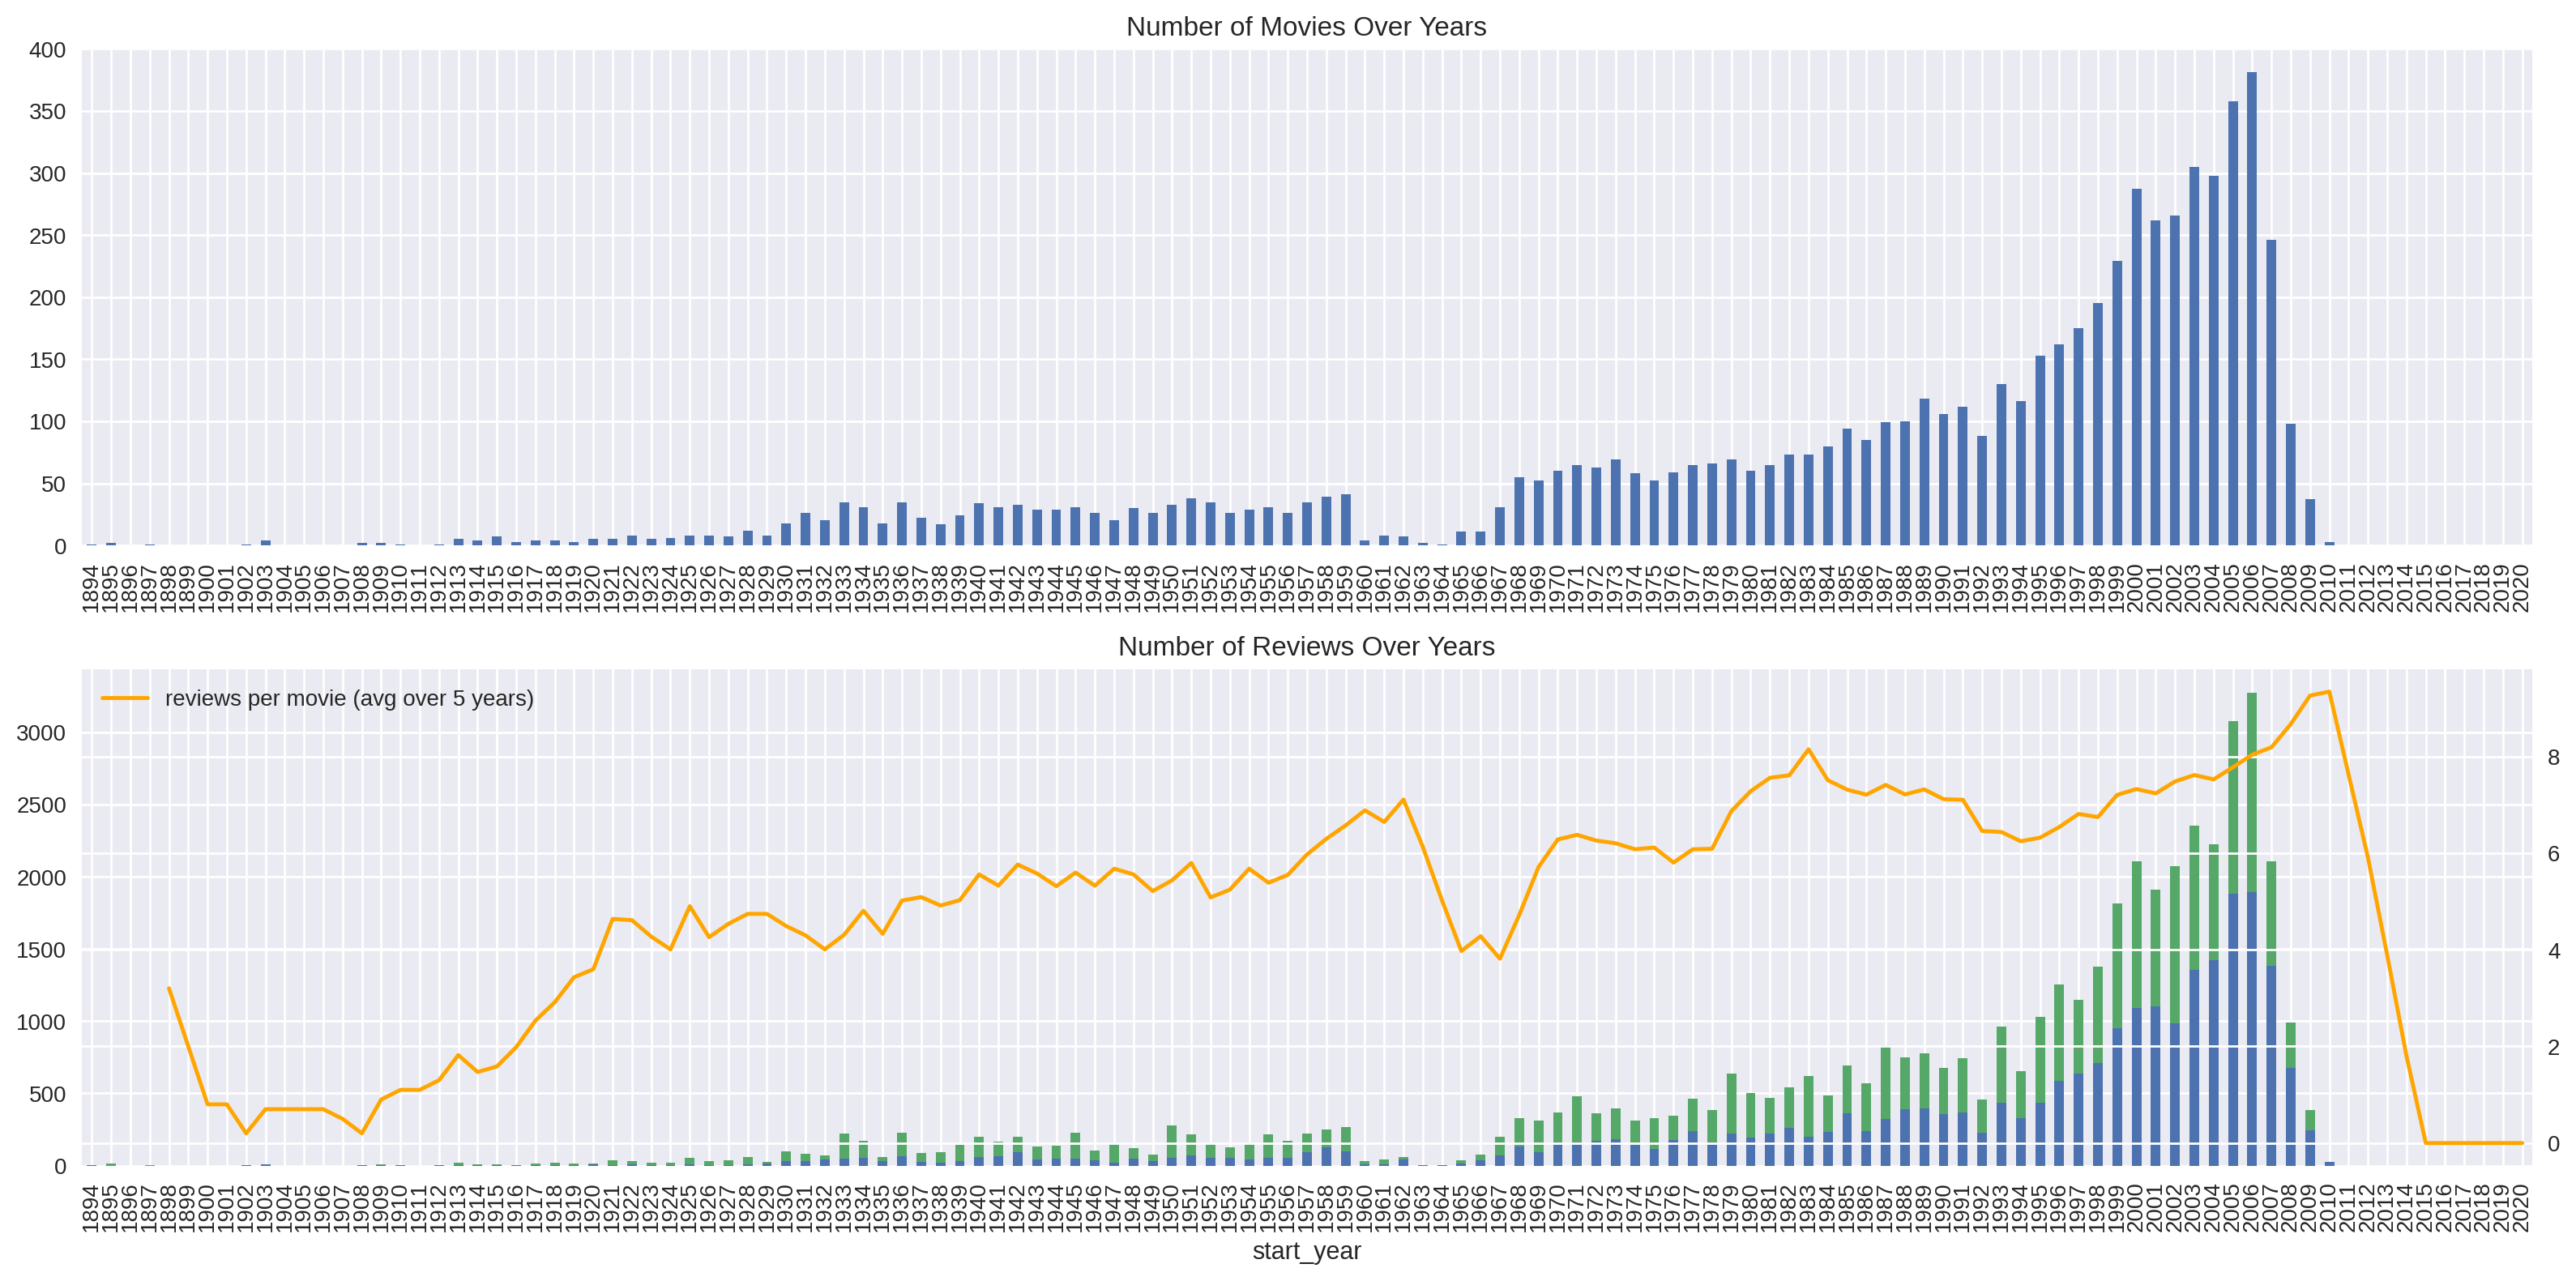

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

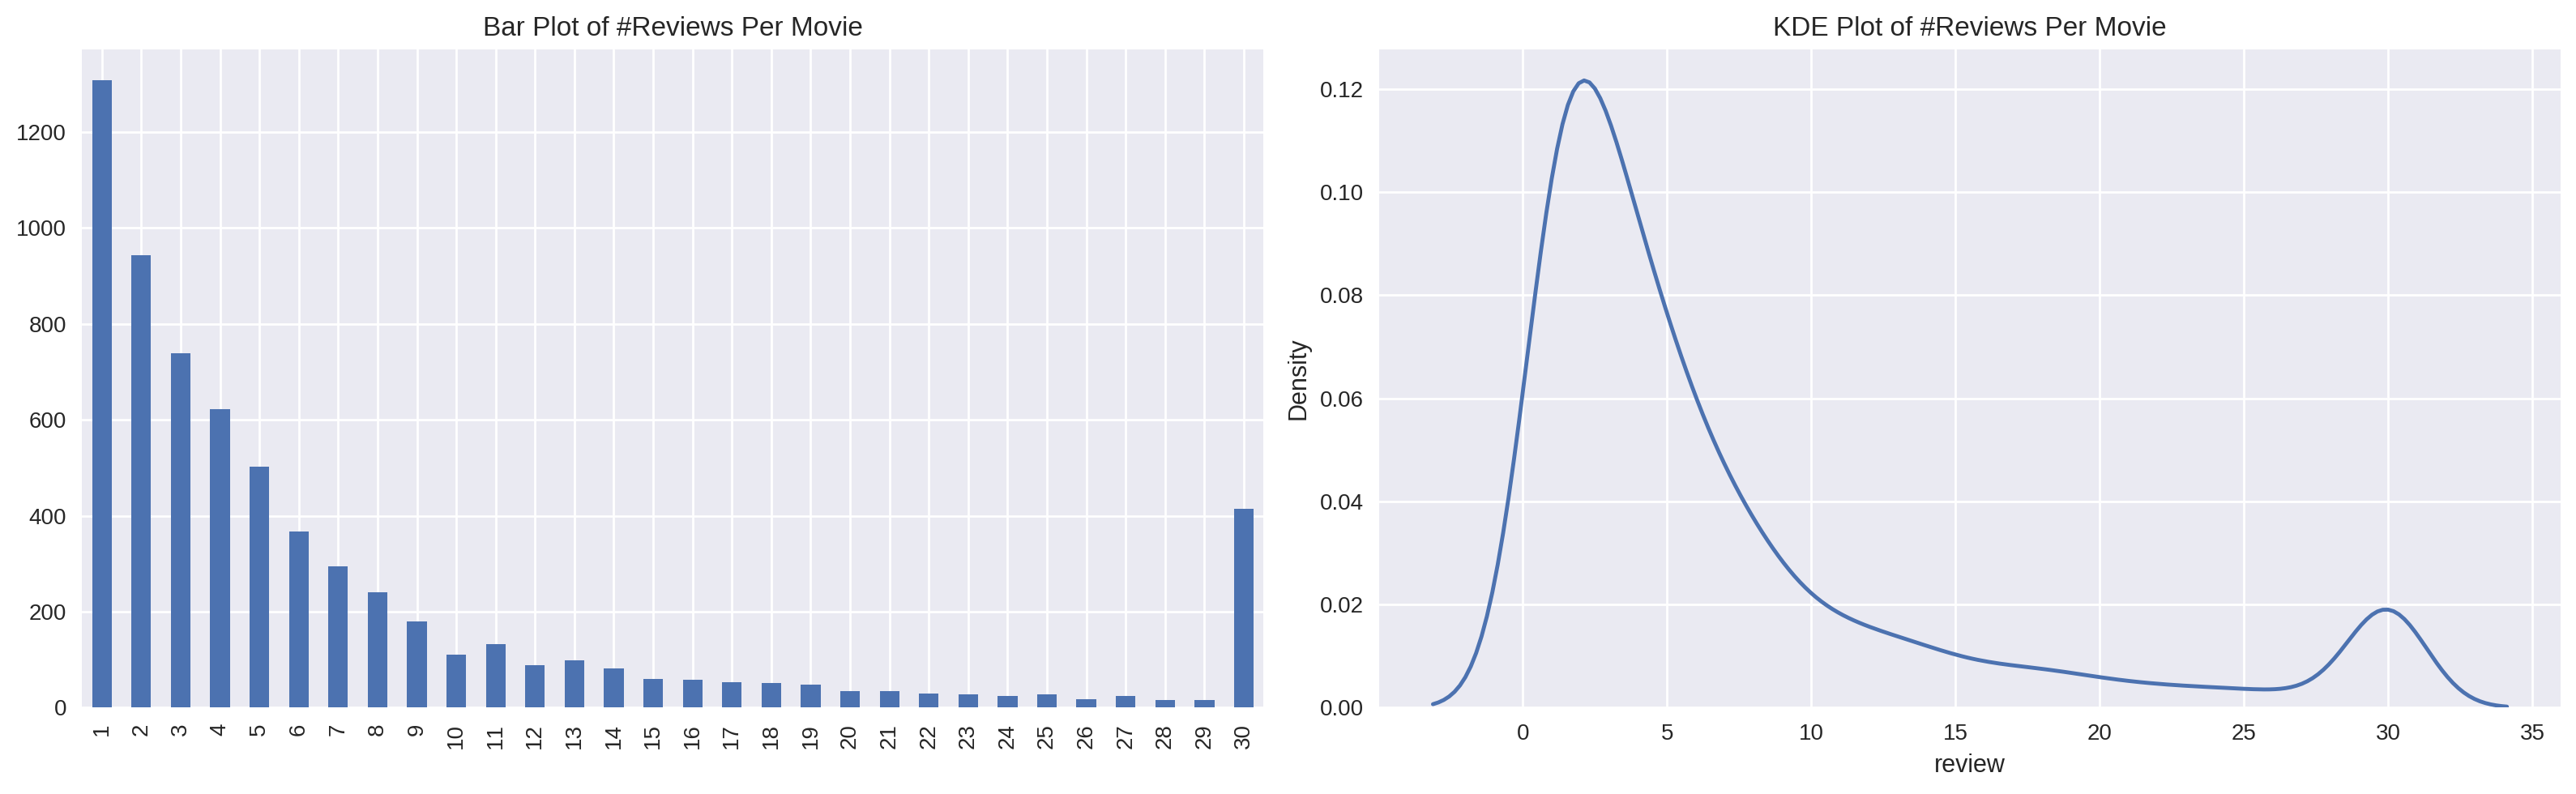

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Sudah sampai bagian 3 dimana kelasnya lumayan seimbang sehingga tidak perlu dilakukan upsampling

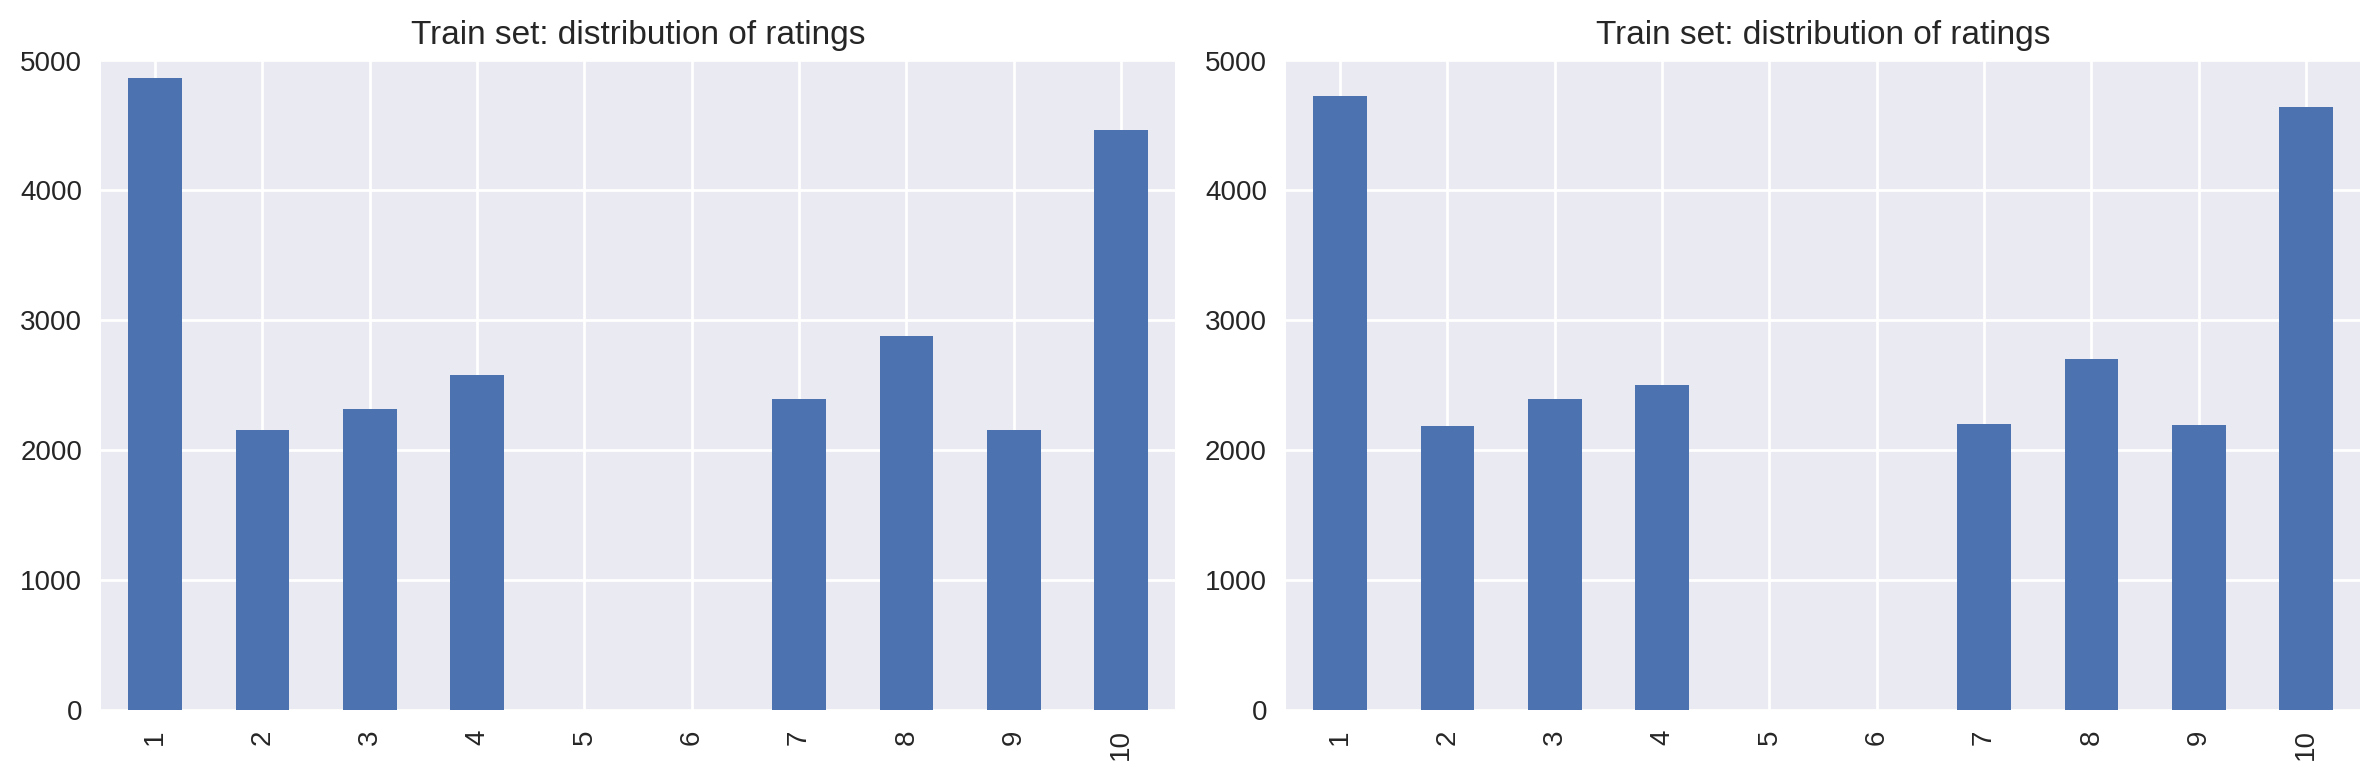

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribution of ratings')

fig.tight_layout()

In [ ]:
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:')
print(dft)
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print()
print('Testing set:')
print(dft)

Training set:
1     4863
2     2155
3     2317
4     2577
7     2393
8     2876
9     2153
10    4462
Name: rating, dtype: int64

Testing set:
1     4726
2     2184
3     2392
4     2501
7     2200
8     2700
9     2189
10    4641
Name: rating, dtype: int64


Distribution of negative and positive reviews over the years for two parts of the dataset

<ipython-input-18-e0e81b3a9b29>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-18-e0e81b3a9b29>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-18-e0e81b3a9b29>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-18-e0e81b3a9b29>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

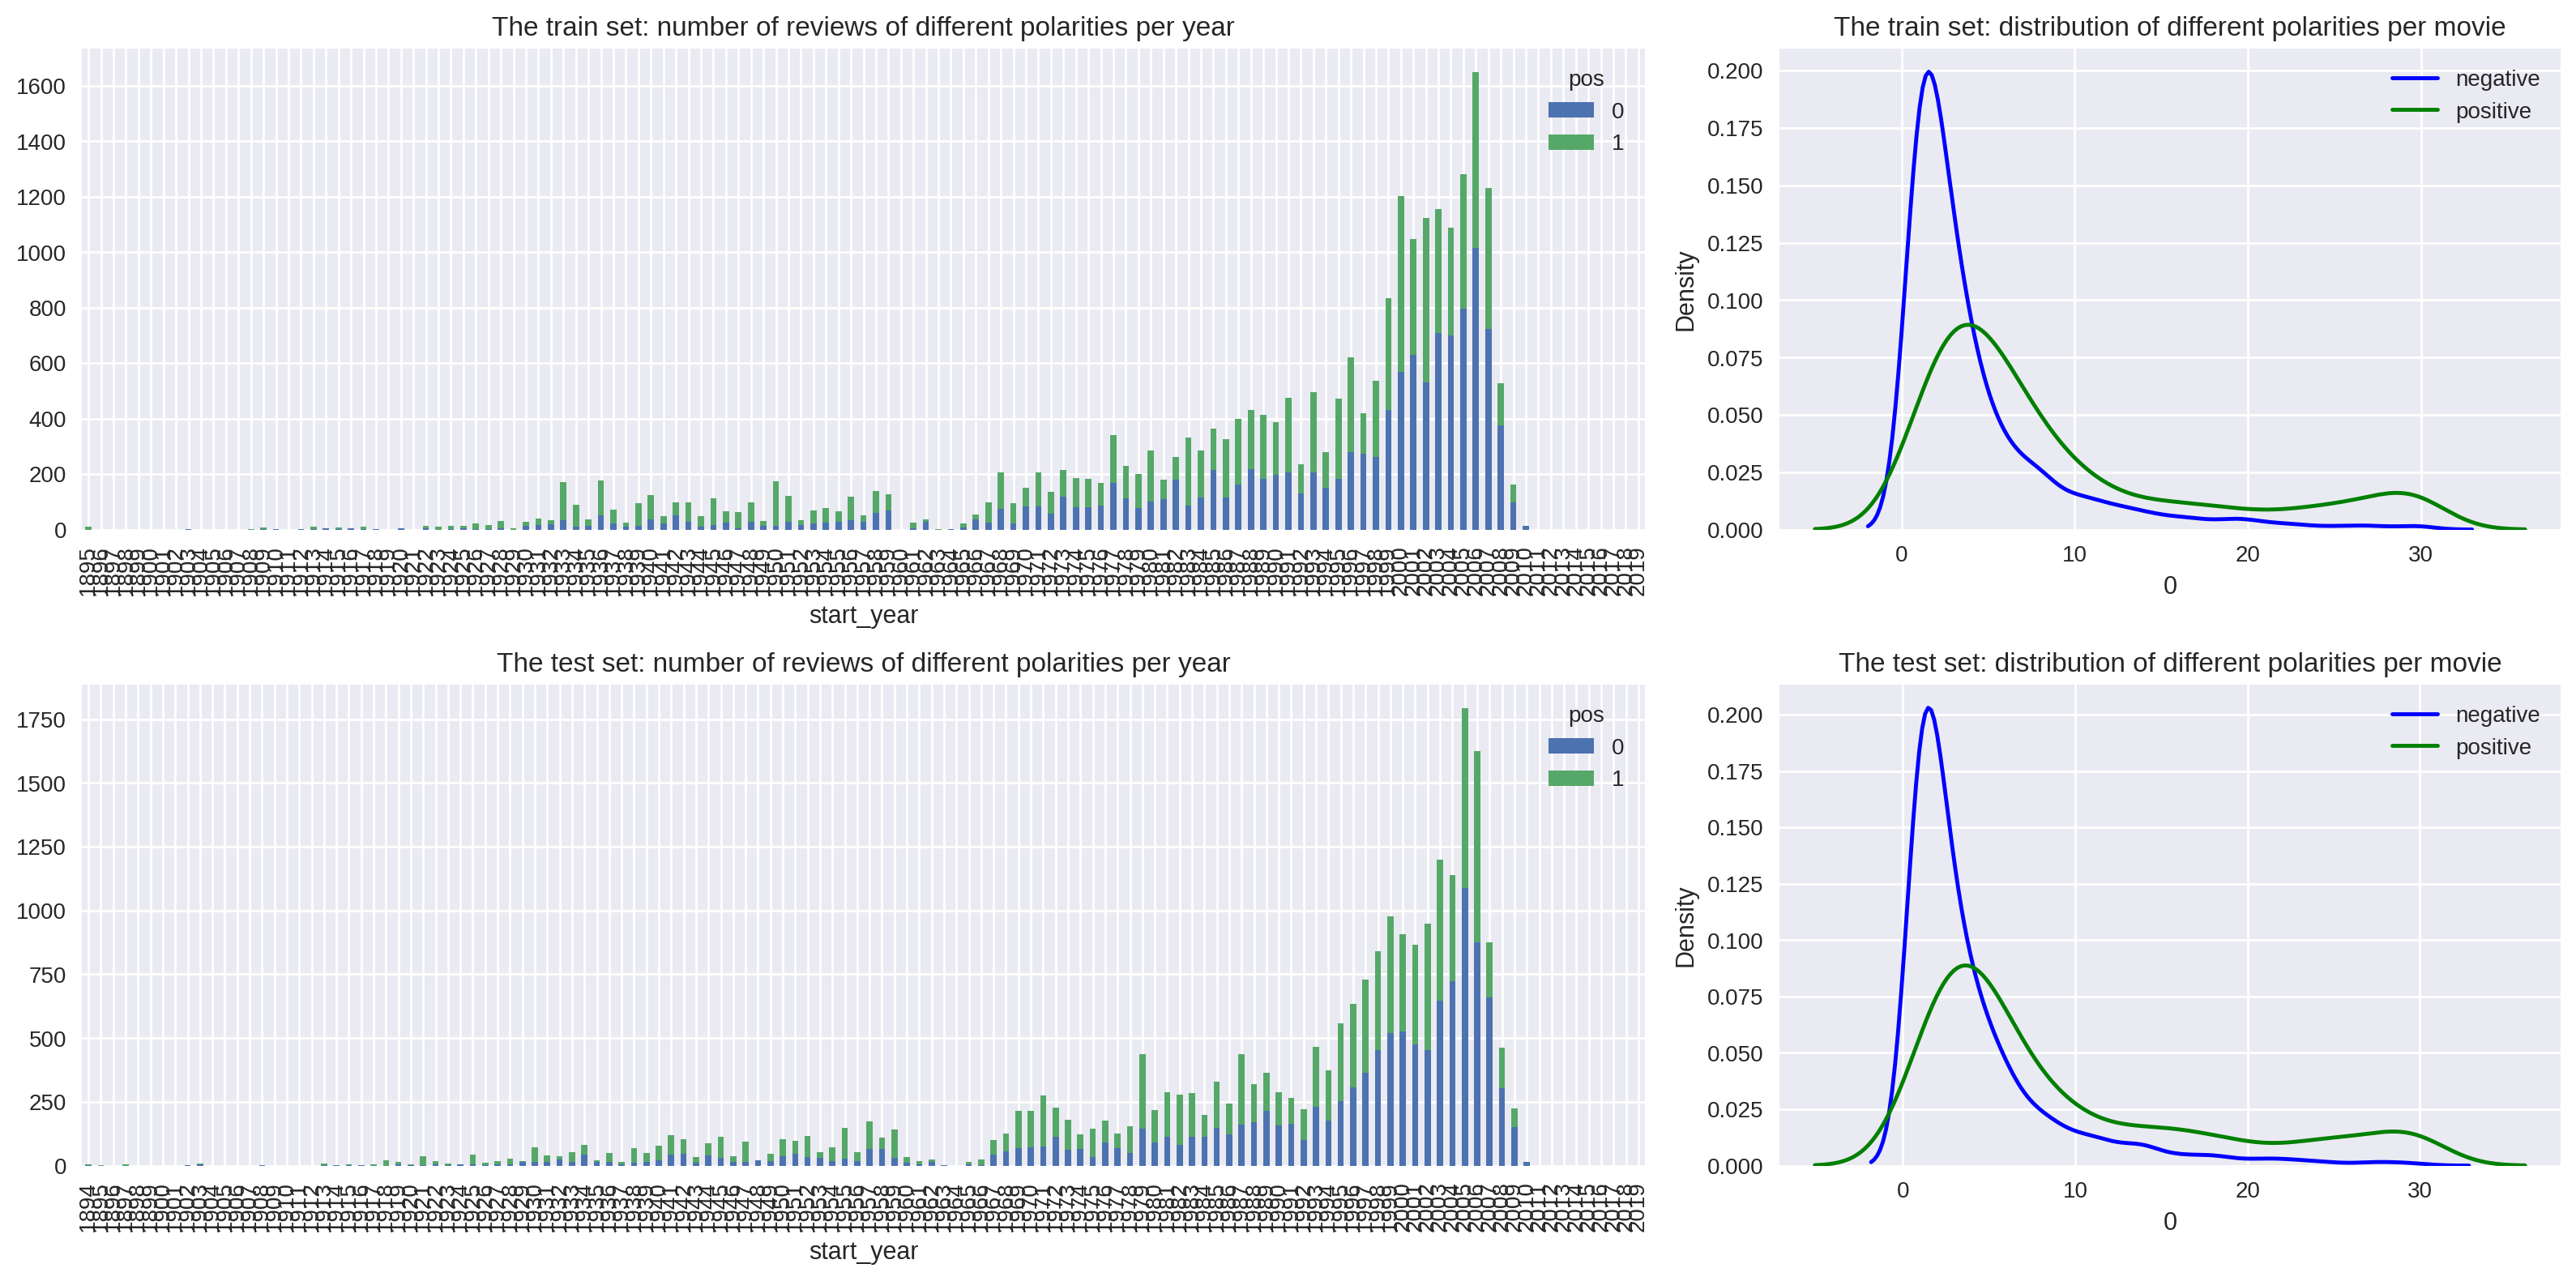

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Based on the visualization, it can be seen that the distribution of data and target between the 'train_dataset' and 'test_dataset' is relatively similar, so there is no need to perform upsampling process.

## Evaluation Procedure

Composing an evaluation function which can be used for all models in this project

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [ ]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: x.lower())

In [ ]:
def apply_pattern(review):
    pattern = r"[^a-z]"
    return re.sub(pattern, " ", review)

df_reviews['review_norm'] = df_reviews['review_norm'].apply(apply_pattern)

In [ ]:
df_reviews['review_norm'][np.random.randint(len(df_reviews))]

'man  this would have been a bad episode of the original series  i can t believe they actually spent money on this one    i caught the second half of this on tv and  having never seen this one before  thought i would watch it    boy  what a waste of time    more cheese than wisconsin    '

## Train / Test Split

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Work with Models

### Model 0 - Konstan

In [ ]:
#Creating encoded dataset.
encoder = LabelEncoder()
reviews_ordinal = df_reviews.copy()
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['original_title'] = encoder.fit_transform(reviews_ordinal['original_title'])
reviews_ordinal['end_year'] = encoder.fit_transform(reviews_ordinal['end_year'])
reviews_ordinal['genres'] = encoder.fit_transform(reviews_ordinal['genres'])
reviews_ordinal['review'] = encoder.fit_transform(reviews_ordinal['review'])
reviews_ordinal['sp'] = encoder.fit_transform(reviews_ordinal['sp'])
reviews_ordinal['ds_part'] = encoder.fit_transform(reviews_ordinal['ds_part'])
reviews_ordinal['tconst'] = encoder.fit_transform(reviews_ordinal['tconst'])

In [ ]:
reviews_ordinal.sample()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
8170,3208,8,1167,1138,1997,59,94,0,48,2.8,1415,7989,1,0,0,0,3101,do not watch this movie or if you are reall...


In [ ]:
df_reviews_train_ordinal = reviews_ordinal.query('ds_part == 1').copy()
df_reviews_test_ordinal = reviews_ordinal.query('ds_part == 0').copy()
train_target_ordinal = df_reviews_train_ordinal['pos']
test_target_ordinal = df_reviews_test_ordinal['pos']
features_train_ordinal = df_reviews_train_ordinal.drop(['pos', 'review_norm'], axis=1)
features_test_ordinal = df_reviews_test_ordinal.drop(['pos', 'review_norm'], axis=1)

In [ ]:
model_0 = DummyClassifier()
model_0.fit(features_train_ordinal, train_target_ordinal)
predictions = model_0.predict(features_test_ordinal)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


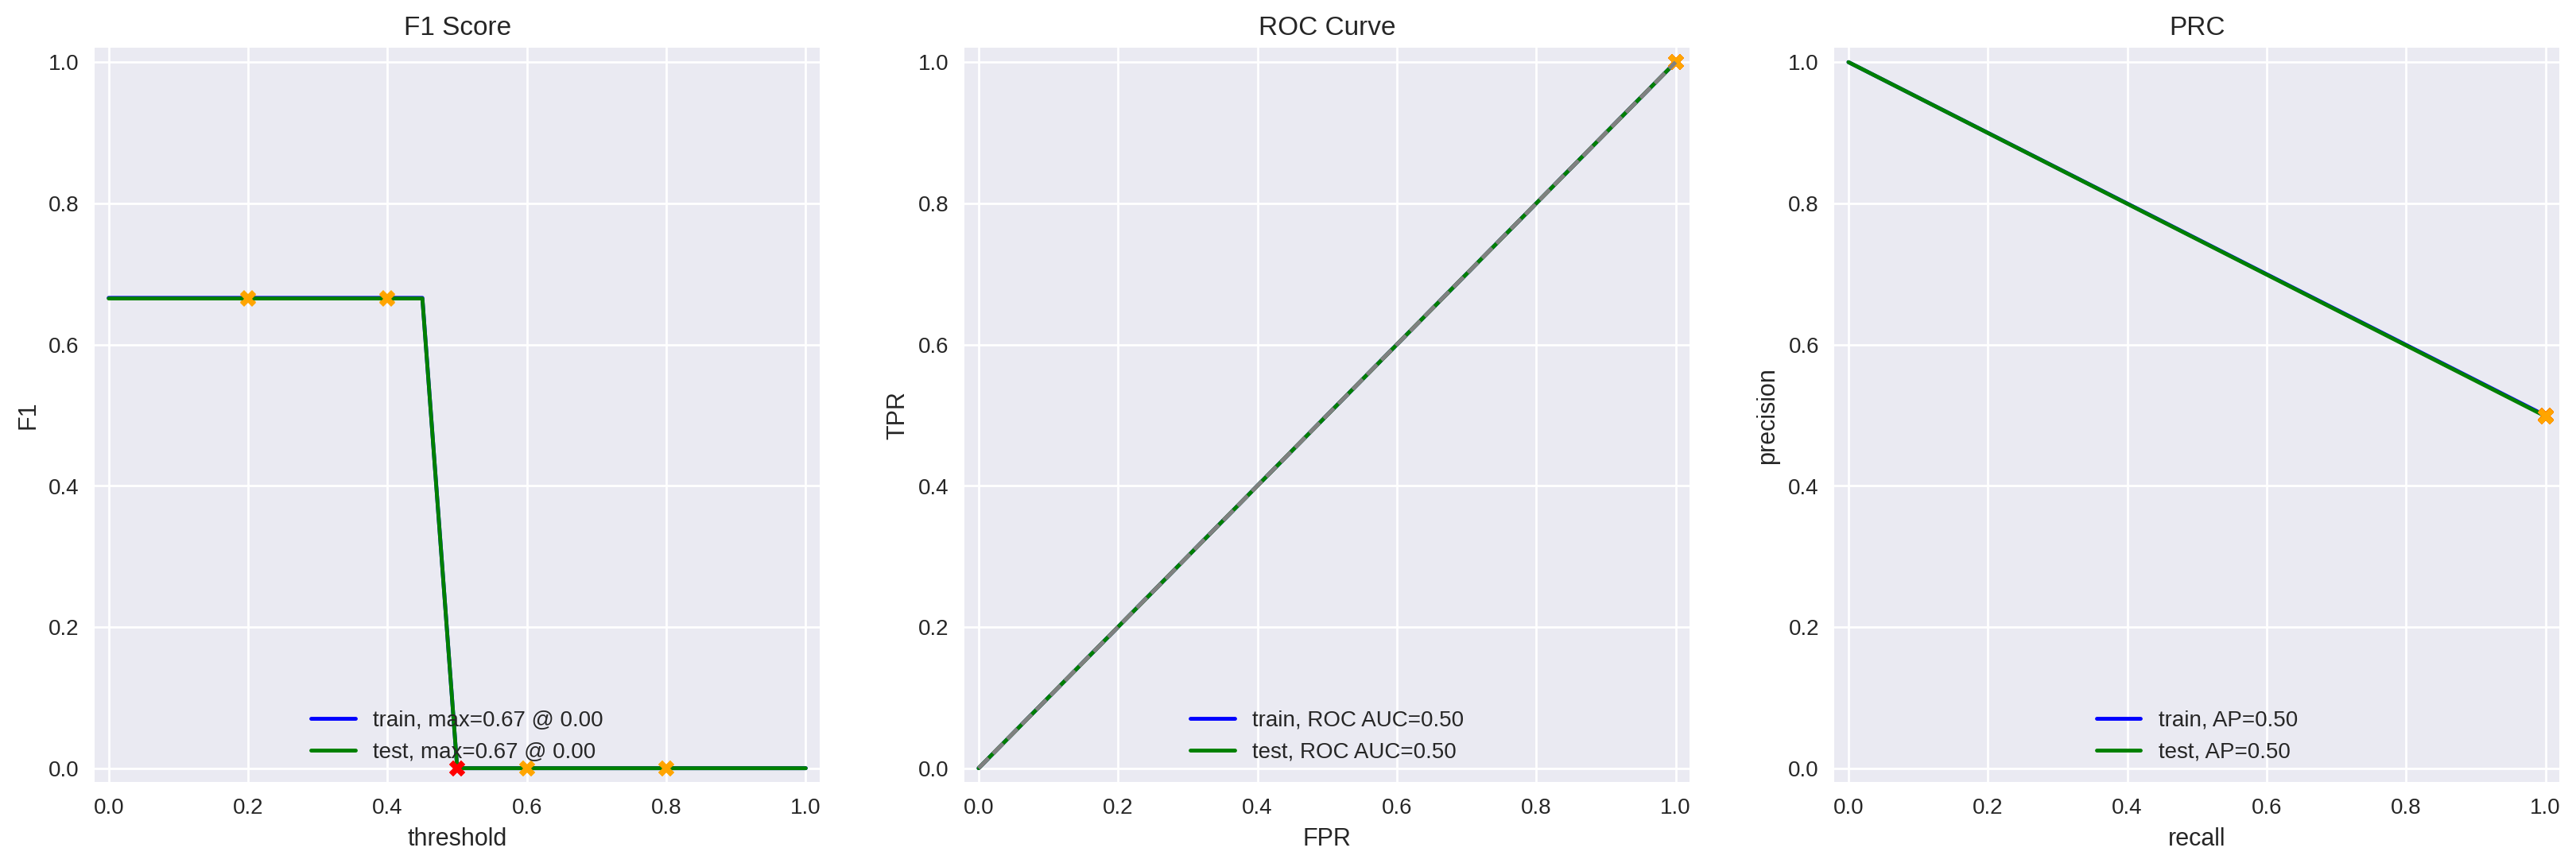

In [ ]:
evaluate_model(model_0, features_train_ordinal, train_target_ordinal, features_test_ordinal, test_target_ordinal)

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_1 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_1)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [ ]:
model_1 = LogisticRegression(solver='lbfgs', random_state = 42)
model_1.fit(train_features_1, train_target)
test_features_1 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_1.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


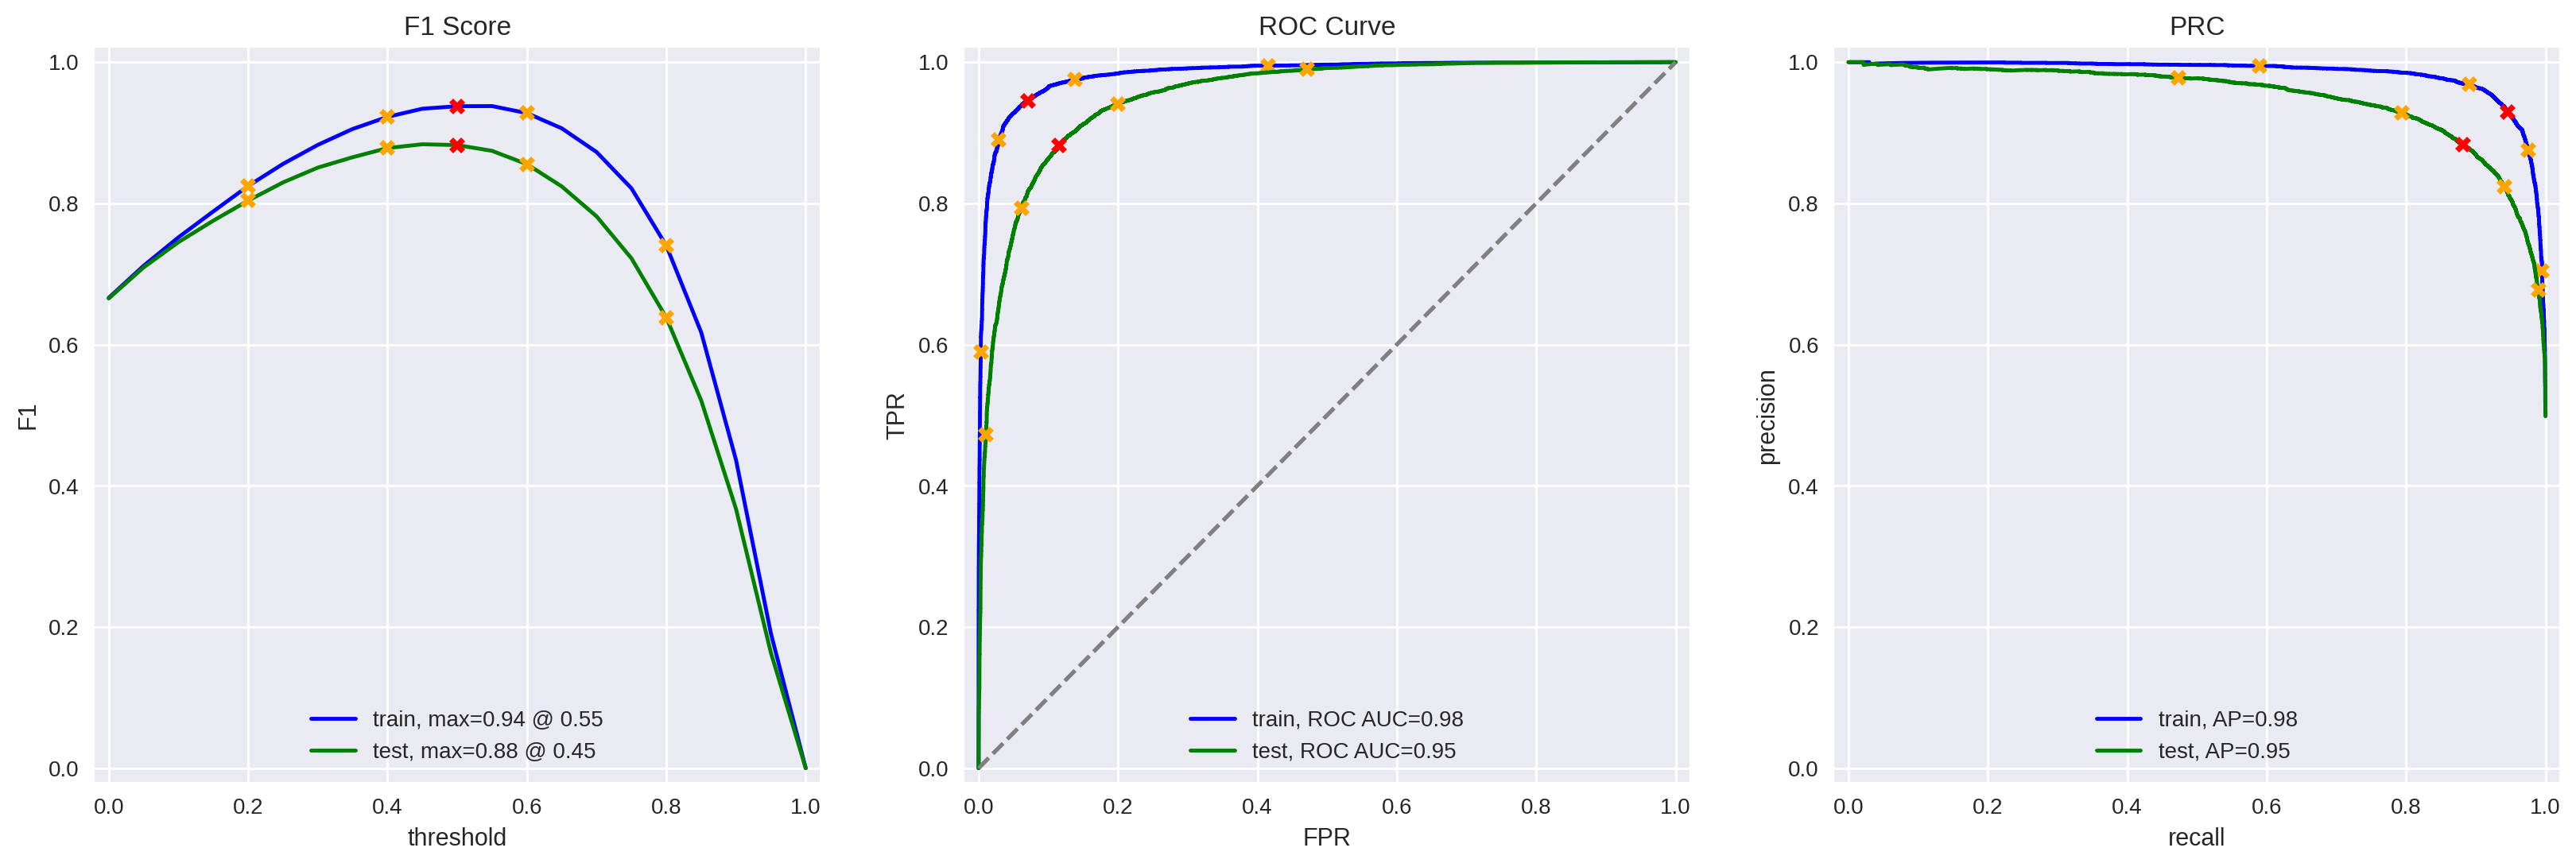

In [ ]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF dan LR

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [ ]:
df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

stop_words = set(stopwords.words('english'))
train_features_2 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_2)

<23796x58813 sparse matrix of type '<class 'numpy.float64'>'
	with 2227348 stored elements in Compressed Sparse Row format>

In [ ]:
model_2 = LogisticRegression(solver='lbfgs', random_state = 42)
model_2.fit(train_features_2, train_target)
test_features_2 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_2.predict(test_features_2)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


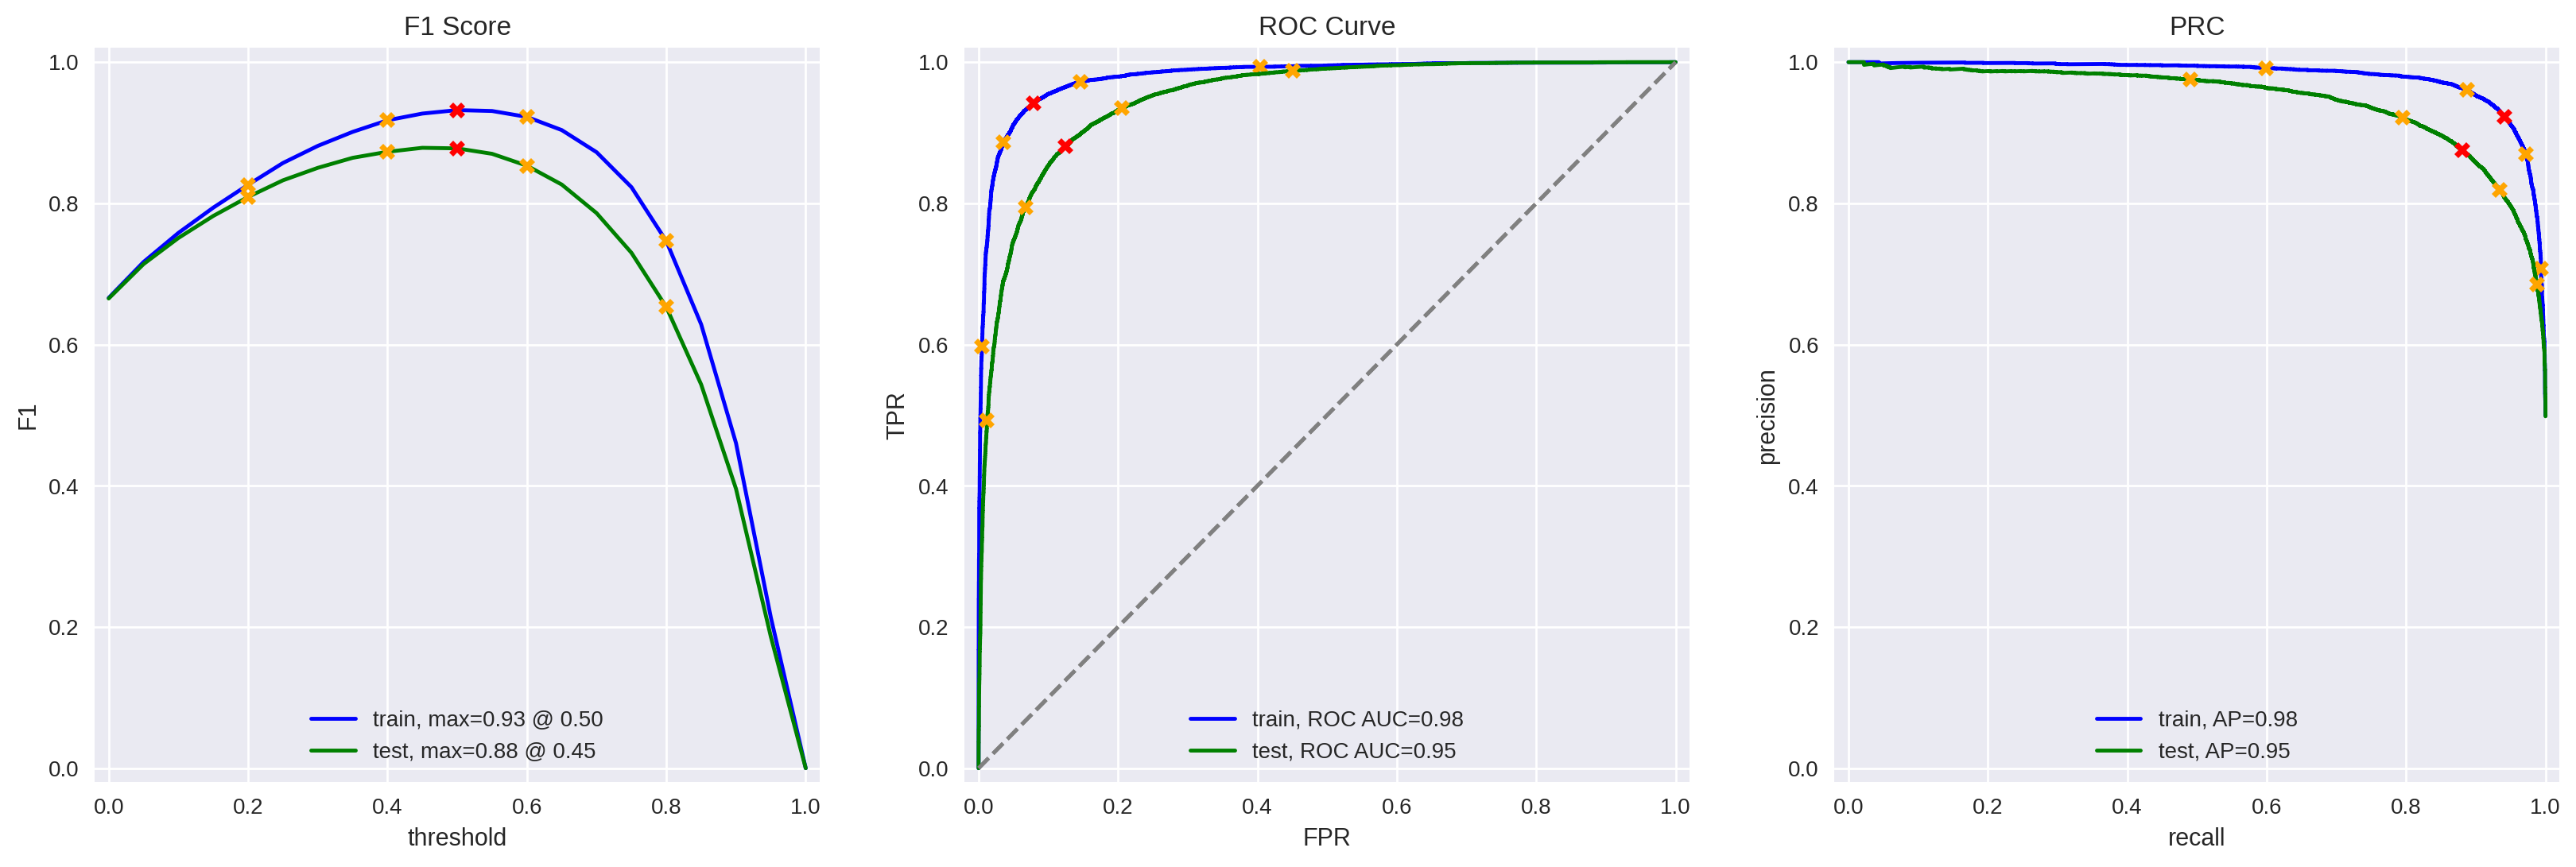

In [ ]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF dan LGBMClassifier

In [ ]:
train_features_3 =  tfidf_vectorizer.fit_transform(corpus_train)
display(train_features_3)

<23796x58813 sparse matrix of type '<class 'numpy.float64'>'
	with 2227348 stored elements in Compressed Sparse Row format>

In [ ]:
model_3 = LGBMClassifier(random_state = 42)
model_3.fit(train_features_3, train_target)
test_features_3 =  tfidf_vectorizer.transform(corpus_test)
predictions = model_3.predict(test_features_3)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


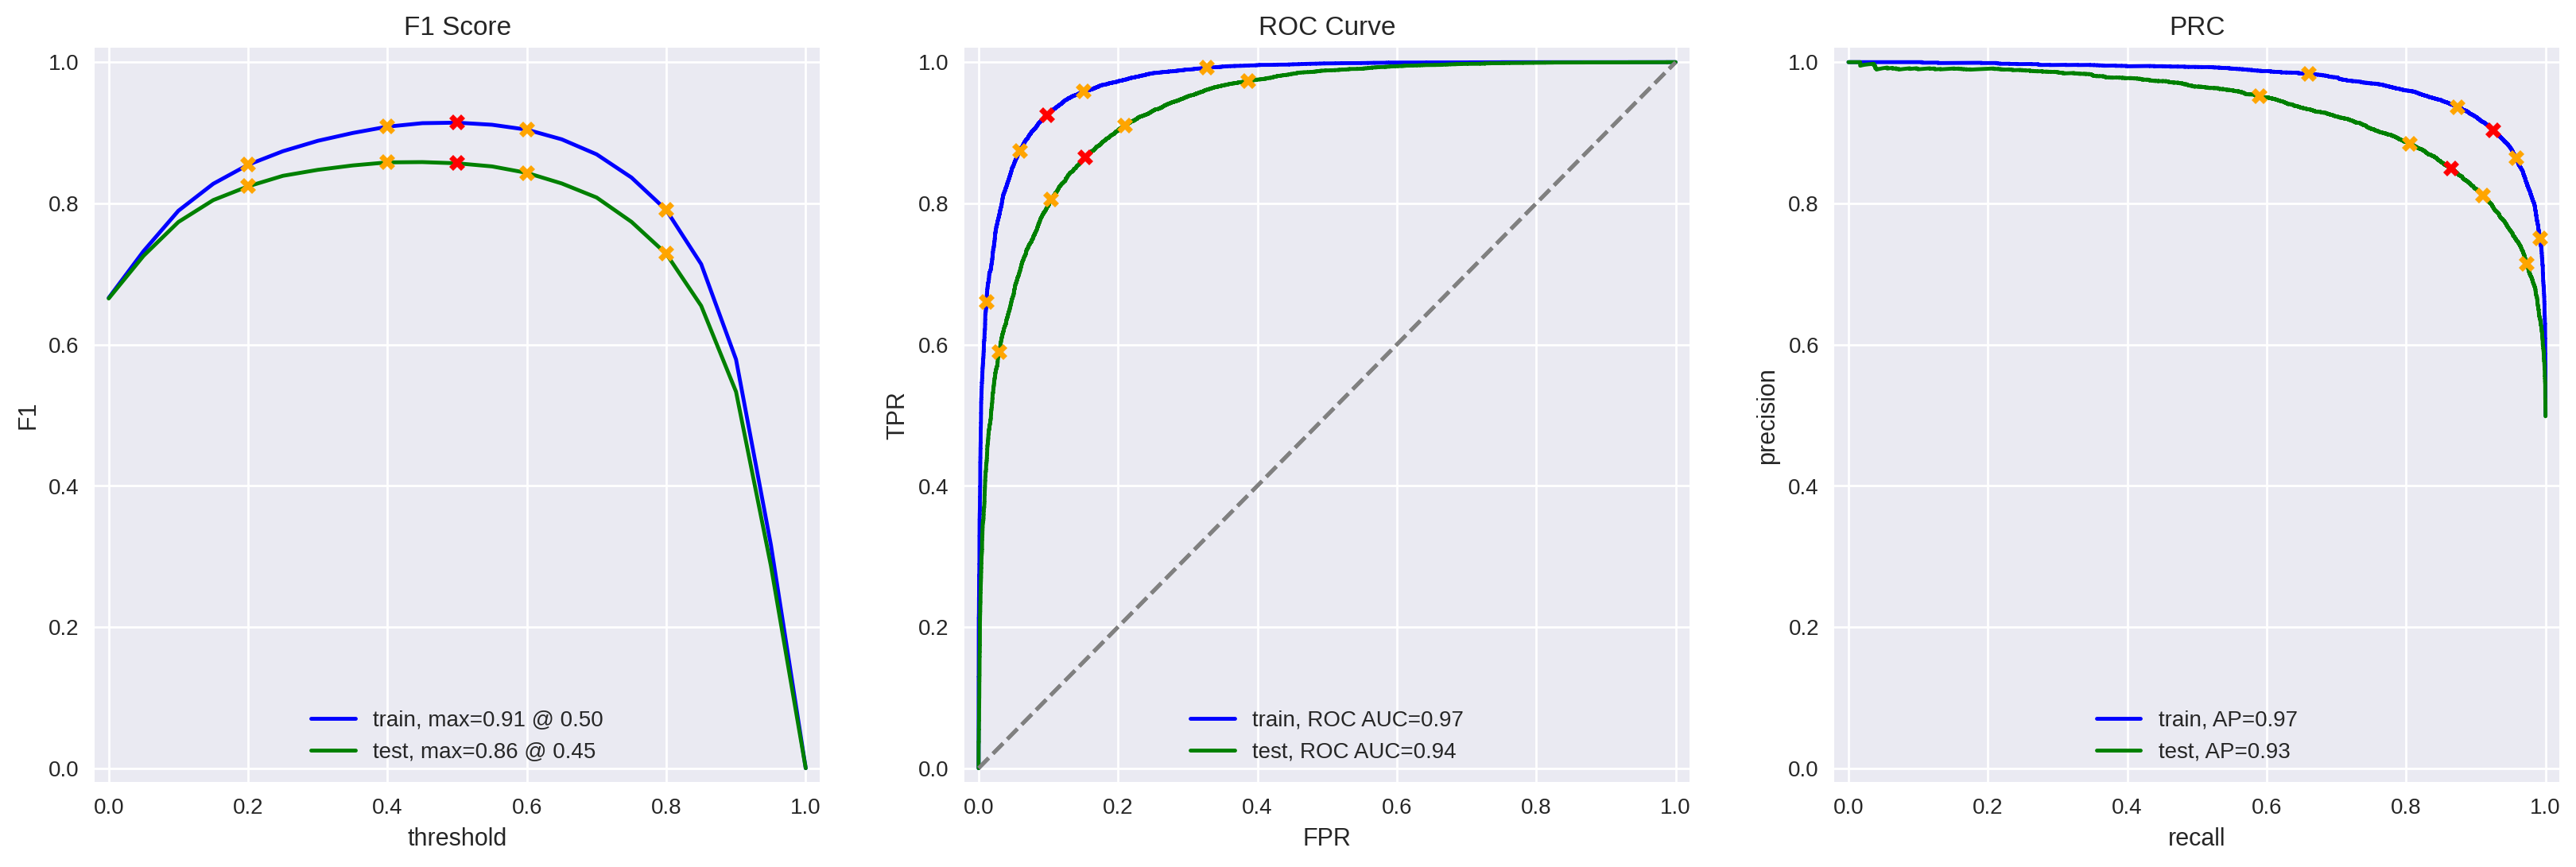

In [ ]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def BERT_text_to_embeddings(texts, max_length=100, batch_size=25, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []
    max_sample_size = 200


    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU.
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-43-ea4210a454f2>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(200, 768)
(23796,)


In [ ]:
max_sample_size = 200
features = train_features_9
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

(200, 768)
(200,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 768)
(100, 768)
(100,)
(100,)


In [ ]:
# train and test your model
model_9 = LogisticRegression(solver='lbfgs')
model_9.fit(X_train,y_train)
model_9.predict(X_test)

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1])

In [ ]:
# saving embeddings
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

          train  test
Accuracy    1.0  0.67
F1          1.0  0.72
APS         1.0  0.76
ROC AUC     1.0  0.69


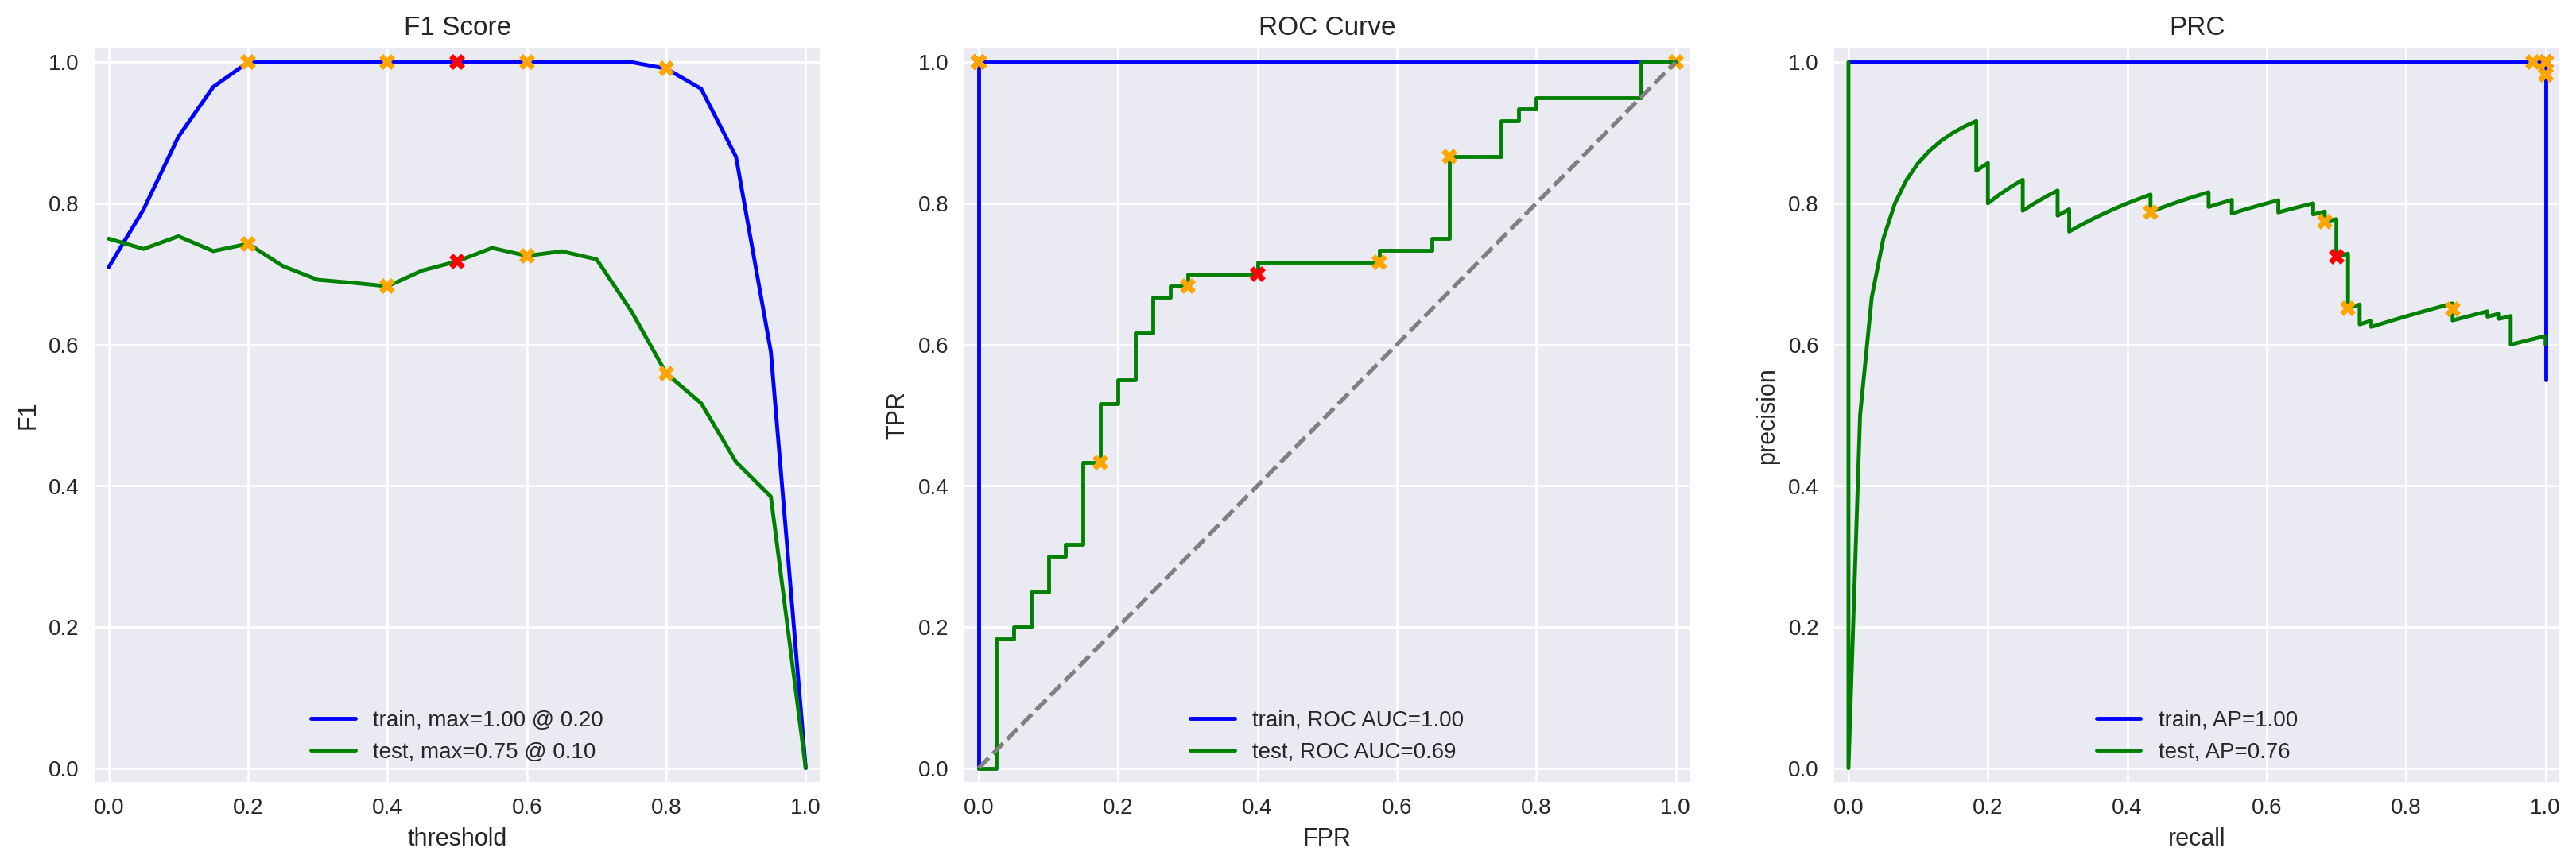

In [ ]:
evaluate_model(model_9, X_train, y_train, X_test, y_test)

## Ulasan Saya

In [ ]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie was hilarious, the actors made me laugh from start to finish of the play',
    'Bad storyline, bad acting, I was really horrified, worst film ever made.',
    "It would be a shame to don't see this movie.",
    'Anyone who is ever watched Sophie Turner on "Game of Thrones" should know that she cannot carry a movie. She is lovely, but has one expression.',
    'A sophomorically conceived film that tries to push every cliched button of the politically correct lunatics that fuel modern Hollywood philosophies. A film that gets into so many false premises that it should have been a black comedy had the filmmakers had the intellectual maturity to satirize such immature writing. Yuk.',
    'What a turkey! A dried up, emaciated and leathery old turkey not even worth cooking. Should have been left for the buzzards. When Pierce Brosnan uttered the zinger when conducting the initial examination, I thought, no way. If this was the premise, why a ham-fisted line like that. Against my better judgement I persisted. Silly me.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: x.lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(apply_pattern)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...
8,"The movie was hilarious, the actors made me la...",the movie was hilarious the actors made me la...
9,"Bad storyline, bad acting, I was really horrif...",bad storyline bad acting i was really horrif...


### Model 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it  not my kind of movie 
0.22:  well  i was bored and felt asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.44:  i didn t expect the reboot to be so good  writers really cared about the source material
0.52:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.05:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.93:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.65:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.03:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.18:  it would be a shame to don t see this movie 
0.79:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it  not my kind of movie 
0.43:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.64:  i didn t expect the reboot to be so good  writers really cared about the source material
0.71:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.25:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.76:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.71:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.09:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.67:  it would be a shame to don t see this movie 
0.62:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it  not my kind of movie 
0.43:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.64:  i didn t expect the reboot to be so good  writers really cared about the source material
0.71:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.25:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.76:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.71:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.09:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.67:  it would be a shame to don t see this movie 
0.62:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.03:  i did not simply like it  not my kind of movie 
0.11:  well  i was bored and felt asleep in the middle of the movie 
0.72:  i was really fascinated with the movie
0.99:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.95:  i didn t expect the reboot to be so good  writers really cared about the source material
0.99:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.49:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.13:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.03:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.77:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.15:  it would be a shame to don t see this movie 
0.70:  anyone who is ever watched sophie turner on  game of thrones  should know

## Summary

Based on the results of the model creation experiment using four models, here is a summary of the F1 scores:

1. Model 1 - NLTK, TF-IDF, and LR produced an F1 score of 0.94 (train) and 0.88 (test)
2. Model 2 - spaCy, TF-IDF, and LR produced an F1 score of 0.93 (train) and 0.88 (test)
3. Model 3 - spaCy, TF-IDF, and LGBM produced an F1 score of 0.91 (train) and 0.88 (test)
Model 4 - BERT produced an F1 score of 1.00 (train) and 0.72 (test)

BERT was the only model to don't accomplish at least 0.85 in testing phase as F1 score but this depended on the fact that my BERT model was obtained just on a 500 sample (since working on CPU), I am pretty sure that training the model on the entire dataset the threshold is going to get reached and probably this model can accomplish even better results compared to the others.



